In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import find_peaks

In [2]:
df = pd.read_csv('../data_raw/ventas.csv')
df.head()

,ID_Venta,Fecha,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado
0,919,31/01/2024,10,25,5,1,Completa
1,947,31/01/2024,106,5,1,4,Completa
2,1317,31/1/2024,235,25,3,3,Completa
3,1607,31/1/2024,114,15,5,1,Completa
4,2038,31/1/2024,132,2,5,4,Completa


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029 entries, 0 to 3028
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID_Venta     3029 non-null   int64 
 1   Fecha        3029 non-null   object
 2   ID_Cliente   3029 non-null   int64 
 3   ID_Producto  3029 non-null   int64 
 4   Cantidad     3029 non-null   int64 
 5   Método_Pago  3029 non-null   int64 
 6   Estado       3029 non-null   object
dtypes: int64(5), object(2)
memory usage: 165.8+ KB


In [4]:
df.describe()

,ID_Venta,ID_Cliente,ID_Producto,Cantidad,Método_Pago
count,3029.000000,3029.000000,3029.000000,3029.000000,3029.000000
mean,1492.663585,162.208320,19.675801,3.475404,3.359194
std,865.690540,94.276683,10.989542,1.702960,1.425749
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,729.000000,79.000000,10.000000,2.000000,2.000000
50%,1486.000000,162.000000,20.000000,3.000000,4.000000
75%,2243.000000,243.000000,29.000000,5.000000,5.000000
max,3000.000000,326.000000,38.000000,6.000000,5.000000


In [5]:
# Parece que algunas IDs están duplicadas (min 1, max 3000, count 3029)
print(df['ID_Venta'].value_counts().head())

# Eliminamos duplicados en 'ID_Venta'
df = df.drop_duplicates(subset='ID_Venta')

ID_Venta
670    2
683    2
680    2
672    2
675    2
Name: count, dtype: int64


In [6]:
categorias = pd.read_csv('../data_raw/categorias.csv')
productos = pd.read_csv('../data_raw/productos.csv')
clientes = pd.read_csv('../data_raw/clientes.csv')

# Agregar a df la categoria de product desde productos
df = df.merge(productos[['ID_Producto', 'Categoría']], on='ID_Producto', how='left')

# Agregamos ID_Categoria desde categorias
df = df.merge(categorias[['Categoría', 'ID_Categoria']], on='Categoría', how='left')

# Agregamos Precio_Unitario desde productos
df = df.merge(productos[['ID_Producto', 'Precio_Unitario']], on='ID_Producto', how='left')

# Agregamos Región desde clientes por ID_Cliente
df = df.merge(clientes[['ID_Cliente', 'Región']], on='ID_Cliente', how='left')

df = df.rename(columns={'Categoría': 'Categoria', 'Región': 'Region'})

df.set_index('ID_Venta', inplace=True)
df = df.sort_index()

df.head()

,Fecha,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado,Categoria,ID_Categoria,Precio_Unitario,Region
ID_Venta,,,,,,,,,,
1,28/08/2024,298,17,1,3,Completa,Frutas y Verduras,4,"6,54",Buenos Aires
2,01/06/2024,37,15,3,1,Completa,Panadería,3,"3,51",Cuyo
3,29/02/2024,31,21,3,3,Completa,Frutas y Verduras,4,"3,25",Centro
4,26/09/2024,111,37,5,4,Completa,Conservas,8,"3,65",Cuyo
5,06/09/2024,188,4,4,4,Completa,Lácteos,1,"19,23",Cuyo


In [7]:
# Limpieza de datos
# Precio_Unitario esta como x,xx en vez de x.xx
df['Precio_Unitario'] = df['Precio_Unitario'].str.replace(',', '.').astype(float)
df.head()

,Fecha,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado,Categoria,ID_Categoria,Precio_Unitario,Region
ID_Venta,,,,,,,,,,
1,28/08/2024,298,17,1,3,Completa,Frutas y Verduras,4,6.54,Buenos Aires
2,01/06/2024,37,15,3,1,Completa,Panadería,3,3.51,Cuyo
3,29/02/2024,31,21,3,3,Completa,Frutas y Verduras,4,3.25,Centro
4,26/09/2024,111,37,5,4,Completa,Conservas,8,3.65,Cuyo
5,06/09/2024,188,4,4,4,Completa,Lácteos,1,19.23,Cuyo


In [8]:
# Podemos observar que enero empieza en el 31, por lo que eliminamos ese mes
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y')
print(df.sort_values('Fecha').head())

df = df[df['Fecha'].dt.month != 1]


              Fecha  ID_Cliente  ID_Producto  Cantidad  Método_Pago    Estado  \
ID_Venta                                                                        
947      2024-01-31         106            5         1            4  Completa   
2578     2024-01-31         201           31         6            3  Completa   
2038     2024-01-31         132            2         5            4  Completa   
919      2024-01-31          10           25         5            1  Completa   
1317     2024-01-31         235           25         3            3  Completa   

                    Categoria  ID_Categoria  Precio_Unitario        Region  
ID_Venta                                                                    
947                   Lácteos             1             5.65           NEA  
2578      Galletitas y Snacks             7             5.24     Patagonia  
2038                  Lácteos             1             5.21  Buenos Aires  
919                Congelados             5    

In [9]:
# Creamos tickets (mismo cliente en misma fecha)
df['ID_Ticket'] = df.groupby(['ID_Cliente', 'Fecha']).ngroup()
df.sort_values('ID_Ticket').head()
tickets_multiproducto = len(df) - df['ID_Ticket'].nunique()

print(f'Tickets con multiples productos: {tickets_multiproducto}')

# Imprimimos algunos tickets con multiples productos

# Agrupamos por ID_Ticket y contamos productos
ticket_product_counts = df.groupby('ID_Ticket')['ID_Producto'].count()

multi_product_tickets = df[df.duplicated(subset=['ID_Ticket'], keep=False)]
print(multi_product_tickets.sort_values('ID_Ticket').head(5))

Tickets con multiples productos: 44
              Fecha  ID_Cliente  ID_Producto  Cantidad  Método_Pago    Estado  \
ID_Venta                                                                        
798      2024-07-09          10           24         5            4  Completa   
1103     2024-07-09          10           34         6            5  Completa   
1032     2024-11-10          20            8         2            5  Completa   
709      2024-11-10          20           13         2            3  Completa   
687      2024-11-09          43           30         2            1  Completa   

                    Categoria  ID_Categoria  Precio_Unitario        Region  \
ID_Venta                                                                     
798                Congelados             5            13.54  Buenos Aires   
1103      Galletitas y Snacks             7             5.45  Buenos Aires   
1032               Carnicería             2            16.21          Cuyo   
709   

Notamos que solo hay 44 (de 3000) tickets con mas de un producto. Esto tiene implicaciones en el analisis de valor promedio del ticket y debe ser analizado con el equipo que recolectó los datos.

## EDA

In [10]:
# Cuanto se vende por categoria

df['Monto_Venta'] = df['Cantidad'] * df['Precio_Unitario']
ventas_por_categoria = df.groupby('Categoria')['Monto_Venta'].sum().reset_index()

df['Monto_Venta'].describe()

count    2993.000000
mean       34.362583
std        27.494472
min         3.250000
25%        14.500000
50%        26.160000
75%        46.350000
max       171.360000
Name: Monto_Venta, dtype: float64

In [11]:
# Eliminamos Outliers
Q1 = df['Monto_Venta'].quantile(0.25)
Q3 = df['Monto_Venta'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['Monto_Venta'] < Q1 - 1.5 * IQR) | (df['Monto_Venta'] > Q3 + 1.5 * IQR)]

print(f"Numero de outliers en Monto de Venta: {len(outliers)}")
print(outliers[['Monto_Venta']].sort_values(by='Monto_Venta', ascending=False).head())

df.drop(df[df['Categoria'].isin(outliers['Categoria'])].index, inplace=True)

cantidad_por_categoria = df.groupby('Categoria')['Cantidad'].sum().reset_index()


Numero de outliers en Monto de Venta: 101
          Monto_Venta
ID_Venta             
91             171.36
477            171.36
776            171.36
374            171.36
271            171.36


/tmp/ipykernel_83966/2874918403.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_83966/2874918403.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)


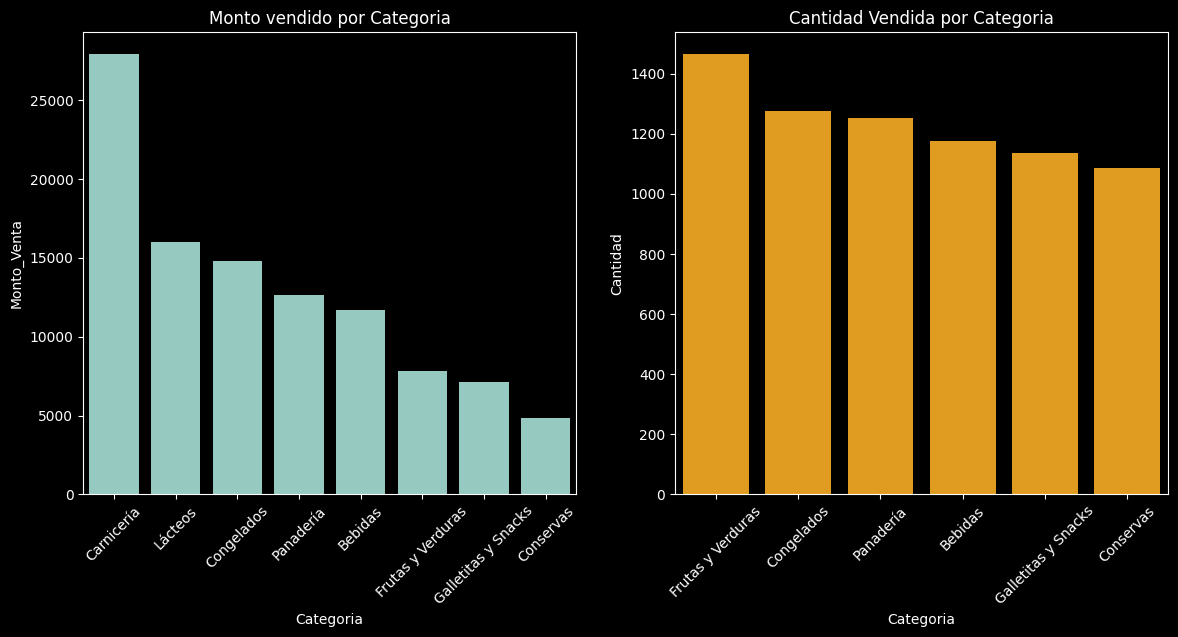

In [12]:
# Plot
ventas_por_categoria = ventas_por_categoria.sort_values(by='Monto_Venta', ascending=False)
cantidad_por_categoria = cantidad_por_categoria.sort_values(by='Cantidad', ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(data=ventas_por_categoria, x='Categoria', y='Monto_Venta', ax=ax[0])
ax[0].set_title('Monto vendido por Categoria')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
sns.barplot(data=cantidad_por_categoria, x='Categoria', y='Cantidad', ax=ax[1], color='orange')
ax[1].set_title('Cantidad Vendida por Categoria')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
plt.show()


Podemos observar que Carnicería es la categoría con mayores ventas en Monto. Sin embargo, en Cantidad, Frutas y Verduras lidera. Esto indica que los productos de Carnicería tienen un precio promedio más alto en comparación con Frutas y Verduras. Estos datos pueden ser útiles para proyecciones financieras y de inventario.

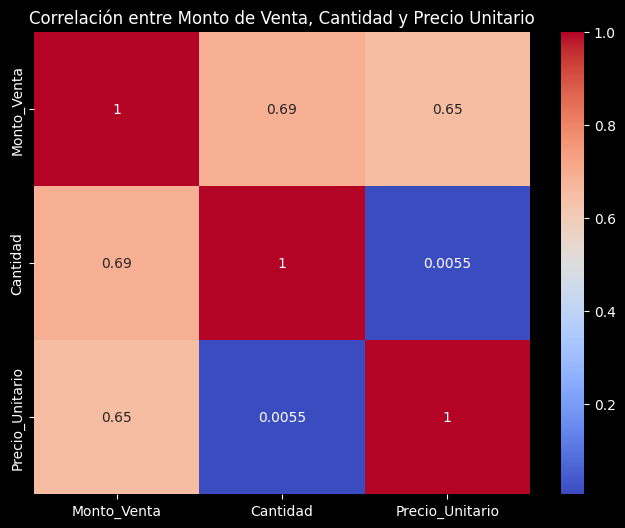

In [13]:
# Correlacion entre Monto  de Venta, Cantidad, y Precio Unitario
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Monto_Venta', 'Cantidad', 'Precio_Unitario']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlación entre Monto de Venta, Cantidad y Precio Unitario')
plt.show()

Podemos ver que el precio unitario afecta el monto de venta un poco más que la cantidad vendida (0.71 vs 0.62). Además, un precio mayor no hace que los clientes compren menos cantidad (correlación positiva de 0.01).

         Region  Cantidad  Clientes  Cantidad_por_Cliente
3          Cuyo      1110        44             25.227273
4           NEA       882        37             23.837838
5           NOA       165         7             23.571429
0  Buenos Aires      2488       111             22.414414
2        Centro      1364        63             21.650794
1     Patagonia      1382        64             21.593750


/tmp/ipykernel_83966/602509258.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(cantidad_sobre_clientes['Region'], rotation=45)


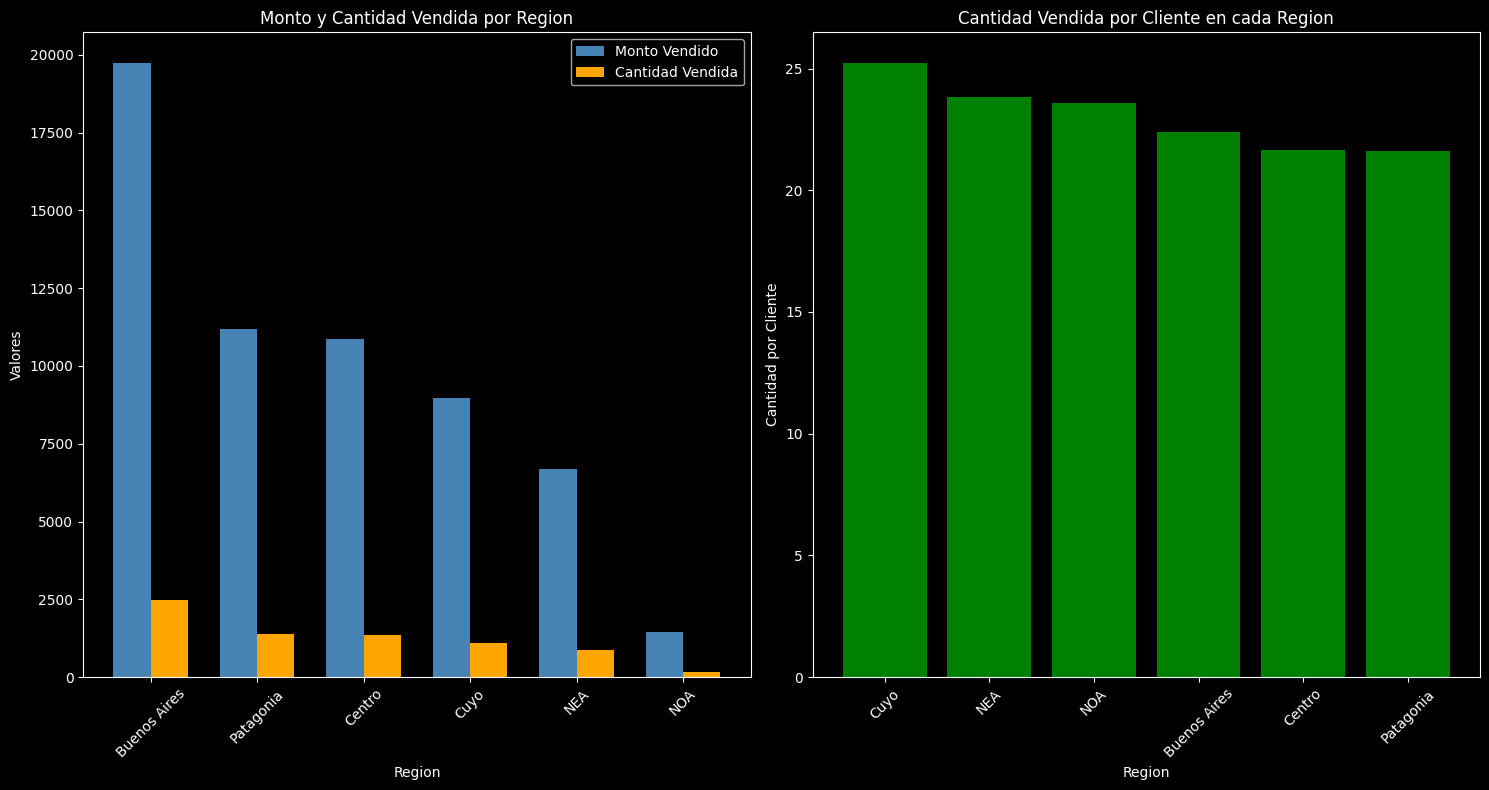

In [14]:
# Cantidad vendida por region
ventas_por_region = df.groupby('Region')['Monto_Venta'].sum().reset_index()
cantidad_por_region = df.groupby('Region')['Cantidad'].sum().reset_index()

# Sort
ventas_por_region = ventas_por_region.sort_values(by='Monto_Venta', ascending=False)
cantidad_por_region = cantidad_por_region.sort_values(by='Cantidad', ascending=False)


# Cantidad vendida por region / clientes en cada region
clientes_por_region = df[['ID_Cliente', 'Region']].groupby('Region')['ID_Cliente'].nunique().reset_index(name='Clientes')

cantidad_sobre_clientes = cantidad_por_region.merge(clientes_por_region, on='Region')
cantidad_sobre_clientes['Cantidad_por_Cliente'] = cantidad_sobre_clientes['Cantidad'] / cantidad_sobre_clientes['Clientes']

# Sort
cantidad_sobre_clientes = cantidad_sobre_clientes.sort_values(by='Cantidad_por_Cliente', ascending=False)

print(cantidad_sobre_clientes)

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
x = np.arange(len(ventas_por_region))
width = 0.35

ax[0].bar(x - width/2, ventas_por_region['Monto_Venta'], width, label='Monto Vendido', color='steelblue')
ax[0].bar(x + width/2, cantidad_por_region['Cantidad'], width, label='Cantidad Vendida', color='orange')

ax[0].set_xlabel('Region')
ax[0].set_ylabel('Valores')
ax[0].set_title('Monto y Cantidad Vendida por Region')
ax[0].set_xticks(x)
ax[0].set_xticklabels(ventas_por_region['Region'], rotation=45)
ax[0].legend()

ax[1].bar(cantidad_sobre_clientes['Region'], cantidad_sobre_clientes['Cantidad_por_Cliente'], color='green')
ax[1].set_xlabel('Region')
ax[1].set_ylabel('Cantidad por Cliente')
ax[1].set_title('Cantidad Vendida por Cliente en cada Region')
ax[1].set_xticklabels(cantidad_sobre_clientes['Region'], rotation=45)

plt.tight_layout()
plt.show()

Podemos ver que Buenos Aires es la región con mayores ventas tanto en monto como en cantidad (son proporcionales, pues a diferencia de las ventas por categoria, los precios por cada región son constantes), mientras que NOA es la región con menores ventas. Sin embargo, esto se debe a las diferencias de población y tamaño de mercado entre regiones.

Notamos que los clientes de Patagonia son los que menos gastan en promedio (29.7), mientras que en Cuyo gastan más (33.3). Esto representa una diferencia de alrededor de 10% 

/tmp/ipykernel_83966/337113275.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ventas_por_mes['Fecha'] = pd.Categorical(ventas_por_mes['Fecha'], categories=pd.date_range(start=df['Fecha'].min(), end=df['Fecha'].max(), freq='M').strftime('%B %Y'), ordered=True)
/tmp/ipykernel_83966/337113275.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)


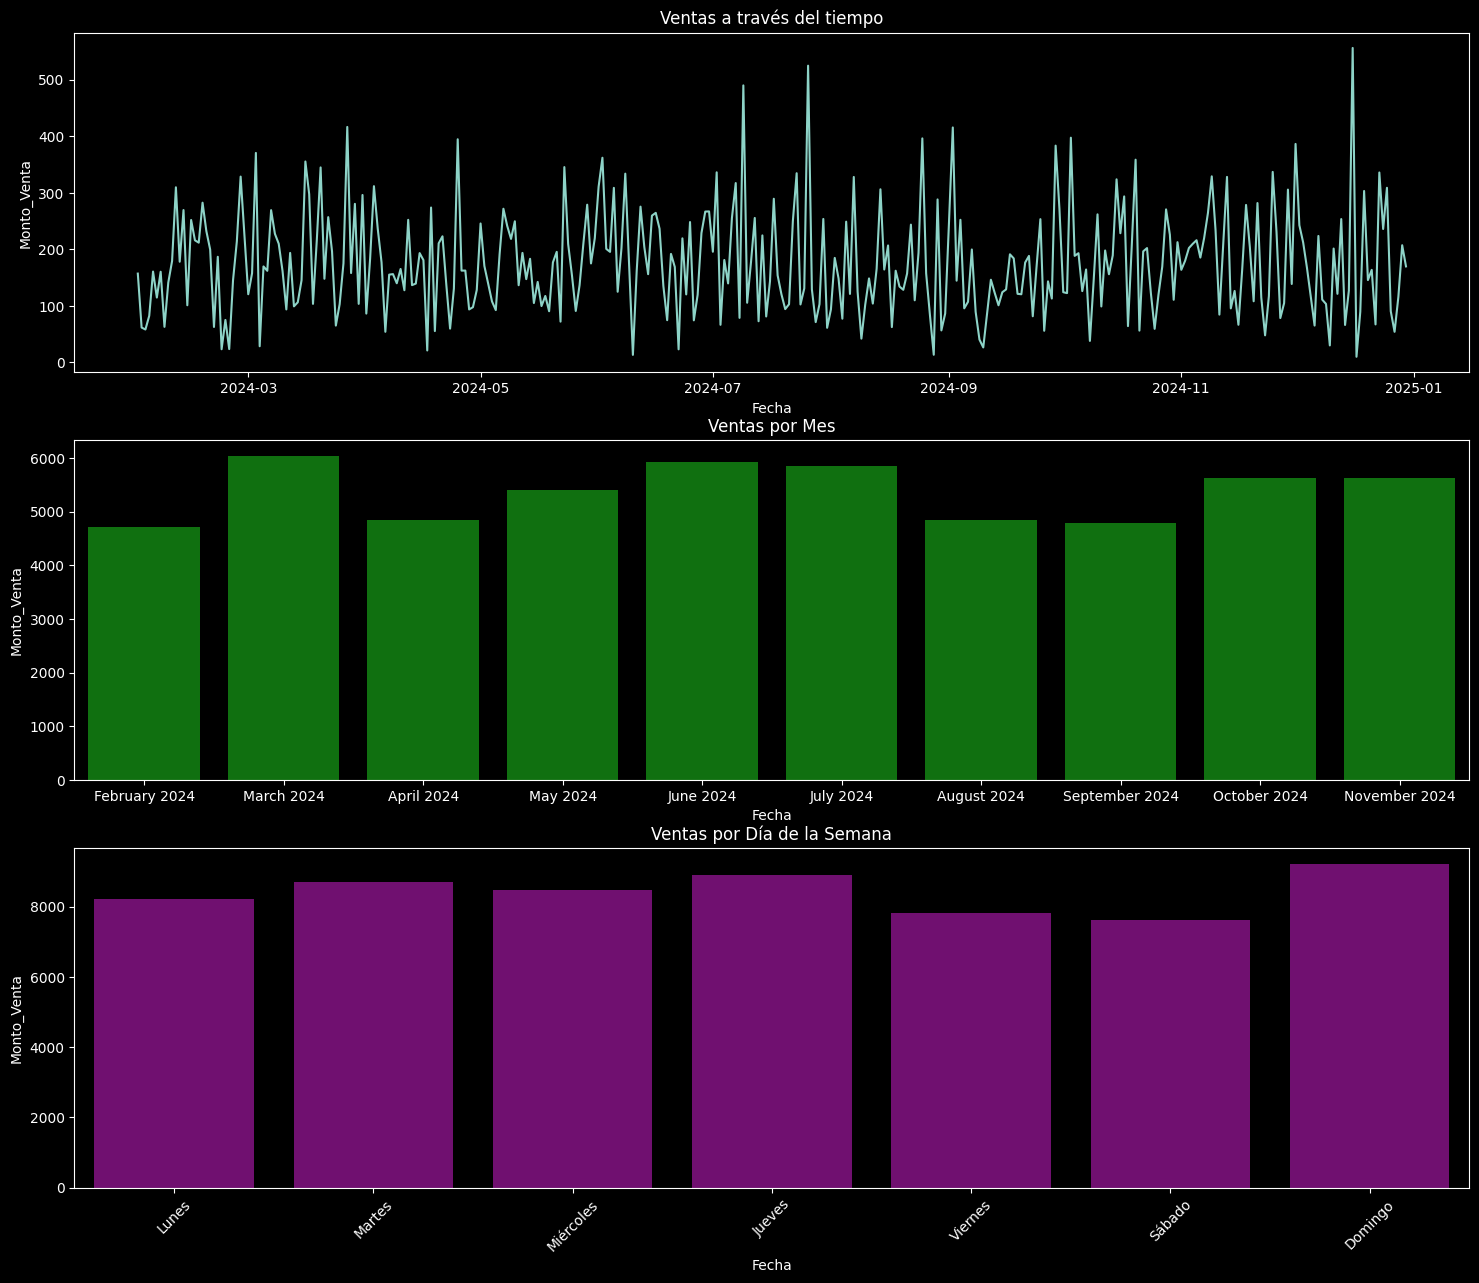

In [15]:
# Ventas a través del tiempo
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
ventas_por_fecha = df.groupby('Fecha')['Monto_Venta'].sum().reset_index()

# Ventas por mes
ventas_por_mes = df.groupby(df['Fecha'].dt.to_period('M'))['Monto_Venta'].sum().reset_index()

# Renombramos a meses
ventas_por_mes['Fecha'] = ventas_por_mes['Fecha'].dt.strftime('%B %Y')
ventas_por_mes['Fecha'] = pd.Categorical(ventas_por_mes['Fecha'], categories=pd.date_range(start=df['Fecha'].min(), end=df['Fecha'].max(), freq='M').strftime('%B %Y'), ordered=True)
ventas_por_mes = ventas_por_mes.sort_values('Fecha')

# Ventas por dia de la semana
ventas_por_dia = df.groupby(df["Fecha"].dt.day_name())['Monto_Venta'].sum().reset_index()

# Renombramos a dias en español y ordenamos
ventas_por_dia['Fecha'] = ventas_por_dia['Fecha'].map({'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles', 'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'})
ventas_por_dia.sort_values(by='Fecha', key=lambda x: x.map({'Lunes': 0, 'Martes': 1, 'Miércoles': 2, 'Jueves': 3, 'Viernes': 4, 'Sábado': 5, 'Domingo': 6}), inplace=True)

fig, ax = plt.subplots(3, 1, figsize=(18, 15))
sns.lineplot(data=ventas_por_fecha, x='Fecha', y='Monto_Venta', ax=ax[0])
ax[0].set_title('Ventas a través del tiempo')
sns.barplot(data=ventas_por_mes, x='Fecha', y='Monto_Venta', ax=ax[1], color='green')
ax[1].set_title('Ventas por Mes')
sns.barplot(data=ventas_por_dia, x='Fecha', y='Monto_Venta', ax=ax[2], color='purple')
ax[2].set_title('Ventas por Día de la Semana')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)
plt.show() 

/tmp/ipykernel_83966/3801958845.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_83966/3801958845.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)


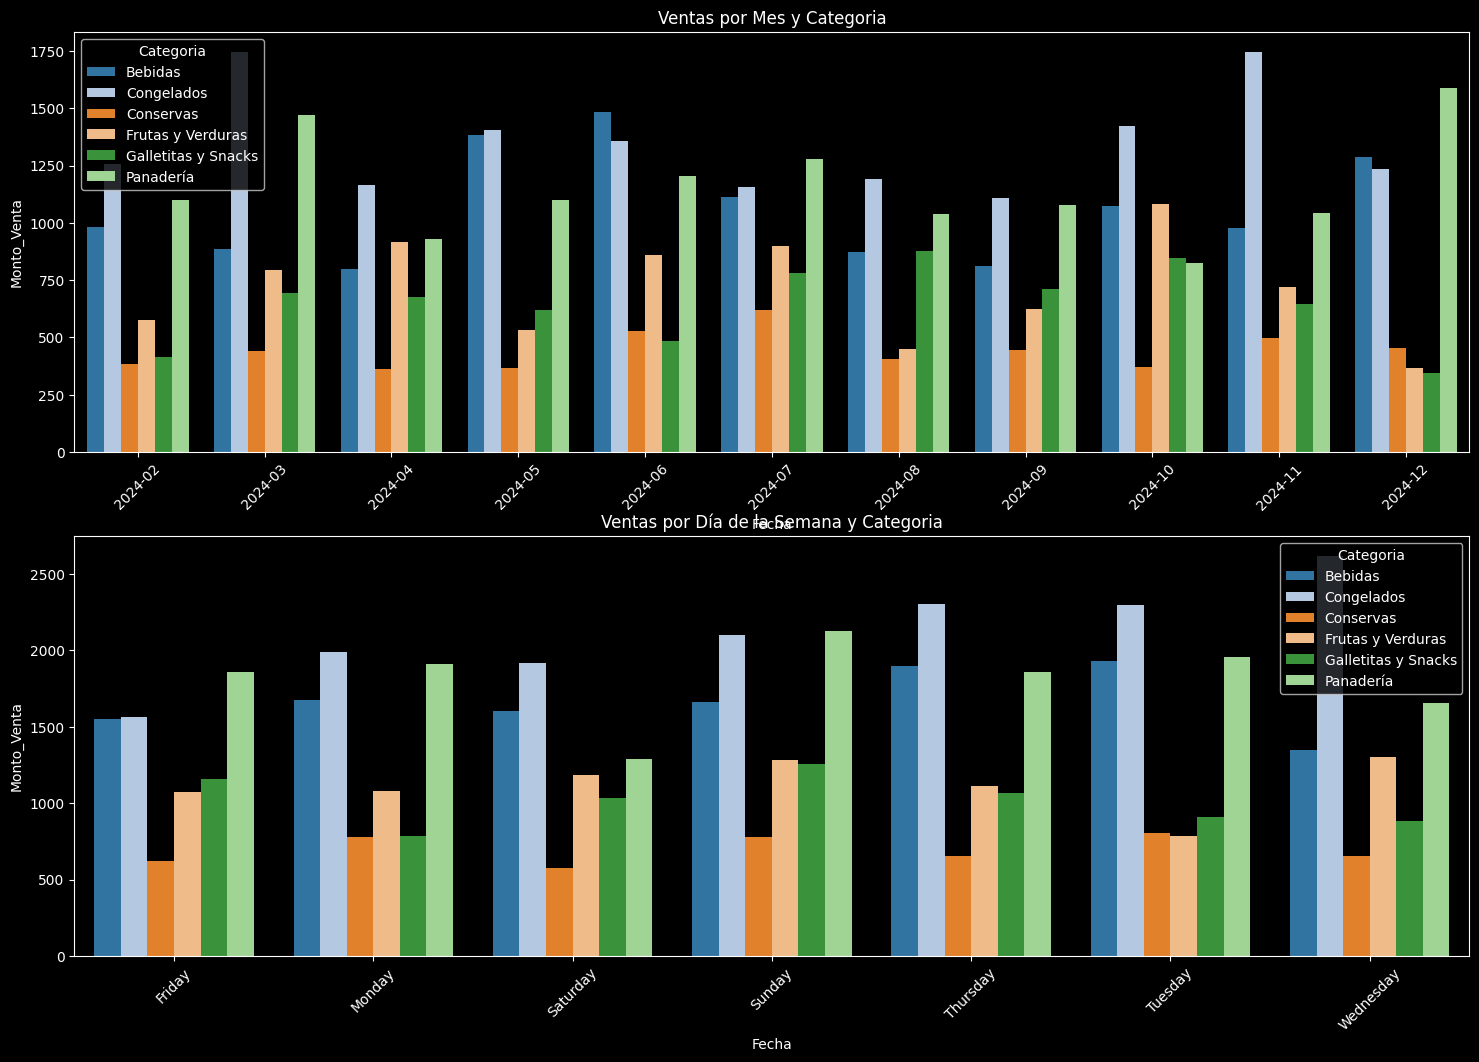

In [16]:
# Ventas por mes y dia por categoría
ventas_por_mes_categoria = df.groupby([df['Fecha'].dt.to_period('M'), 'Categoria'])['Monto_Venta'].sum().reset_index()
ventas_por_dia_categoria = df.groupby([df['Fecha'].dt.day_name(), 'Categoria'])['Monto_Venta'].sum().reset_index()

fig, ax = plt.subplots(2, 1, figsize=(18, 12))
sns.barplot(data=ventas_por_mes_categoria, x='Fecha', y='Monto_Venta', hue='Categoria', ax=ax[0], palette='tab20')
ax[0].set_title('Ventas por Mes y Categoria')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
sns.barplot(data=ventas_por_dia_categoria, x='Fecha', y='Monto_Venta', hue='Categoria', ax=ax[1], palette='tab20')
ax[1].set_title('Ventas por Día de la Semana y Categoria')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
plt.show()

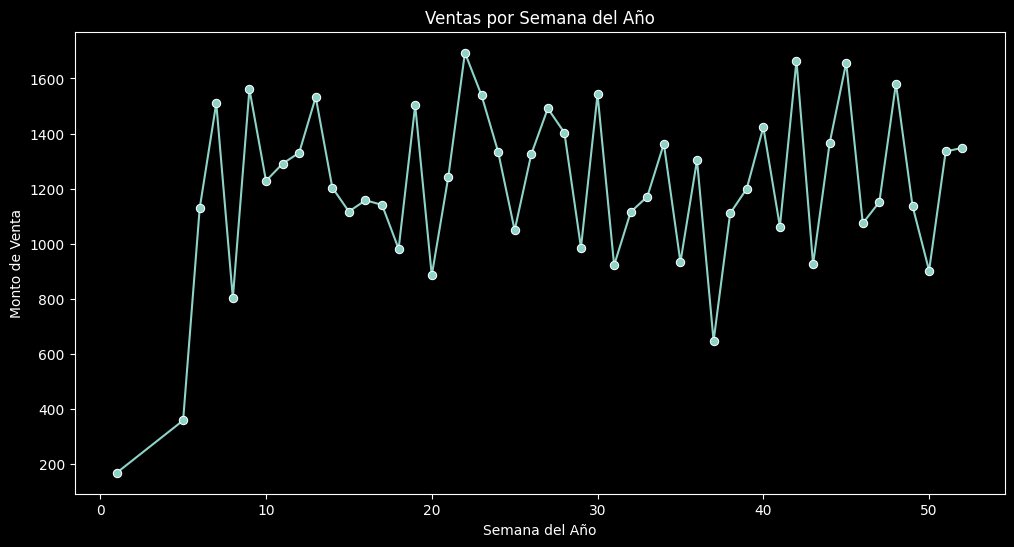

In [17]:
# Cuanto se vende en cada semana del año
df['Semana_Año'] = df['Fecha'].dt.isocalendar().week
ventas_por_semana = df.groupby('Semana_Año')['Monto_Venta'].sum().reset_index()
ventas_por_semana = ventas_por_semana.sort_values(by='Semana_Año')

plt.figure(figsize=(12, 6))
sns.lineplot(data=ventas_por_semana, x='Semana_Año', y='Monto_Venta', marker='o')
plt.title('Ventas por Semana del Año')
plt.xlabel('Semana del Año')
plt.ylabel('Monto de Venta')
plt.show()

## Analisis de demanda a lo largo del tiempo

In [18]:
print('Las fechas con mayores ventas son:')
top_5_fechas = ventas_por_fecha.nlargest(5, 'Monto_Venta')
for index, row in top_5_fechas.iterrows():
    print(f"{row['Fecha'].date()}: {row['Monto_Venta']:.2f}")

print('\nLas fechas con menores ventas son:')
bottom_5_fechas = ventas_por_fecha.nsmallest(5, 'Monto_Venta')
for index, row in bottom_5_fechas.iterrows():
    print(f"{row['Fecha'].date()}: {row['Monto_Venta']:.2f}")

Las fechas con mayores ventas son:
2024-12-16: 555.92
2024-07-26: 524.58
2024-07-09: 489.72
2024-03-27: 416.28
2024-09-02: 415.37

Las fechas con menores ventas son:
2024-12-17: 10.01
2024-06-10: 13.36
2024-08-28: 13.56
2024-04-17: 21.17
2024-06-22: 23.15


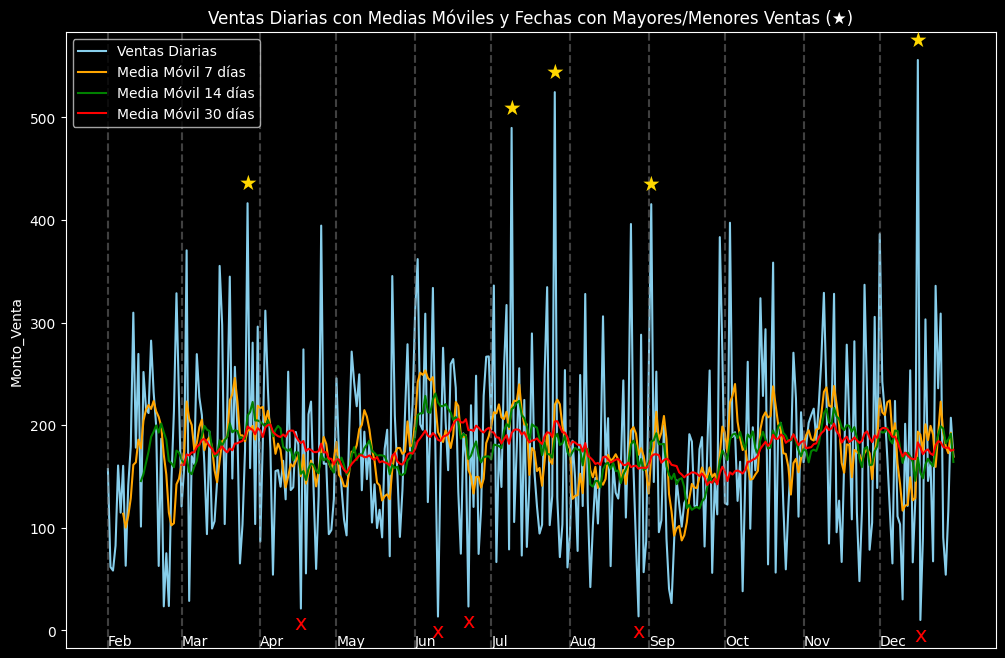

In [19]:
# Media movil de 7, 14 y 30 dias para ventas diarias
ventas_por_fecha['MA7'] = ventas_por_fecha['Monto_Venta'].rolling(window=7).mean()
ventas_por_fecha['MA14'] = ventas_por_fecha['Monto_Venta'].rolling(window=14).mean()
ventas_por_fecha['MA30'] = ventas_por_fecha['Monto_Venta'].rolling(window=30).mean()

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=ventas_por_fecha, x='Fecha', y='Monto_Venta', ax=ax, label='Ventas Diarias', color='skyblue')
sns.lineplot(data=ventas_por_fecha, x='Fecha', y='MA7', ax=ax, label='Media Móvil 7 días', color='orange')
sns.lineplot(data=ventas_por_fecha, x='Fecha', y='MA14', ax=ax, label='Media Móvil 14 días', color='green')
sns.lineplot(data=ventas_por_fecha, x='Fecha', y='MA30', ax=ax, label='Media Móvil 30 días', color='red')

# 5 fechas con mayores ventas
for index, row in top_5_fechas.iterrows():
    ax.annotate('★', xy=(row['Fecha'], row['Monto_Venta']), xytext=(0,10), textcoords='offset points', ha='center', color='gold', fontsize=15)

# 5 fechas con menores ventas
for index, row in bottom_5_fechas.iterrows():
    ax.annotate('x', xy=(row['Fecha'], row['Monto_Venta']), xytext=(0,-15), textcoords='offset points', ha='center', color='red', fontsize=15)

# Lineas verticales por mes
for month_start in pd.date_range(start=ventas_por_fecha['Fecha'].min(), end=ventas_por_fecha['Fecha'].max(), freq='MS'):
    ax.axvline(x=month_start, color='gray', linestyle='--', alpha=0.5)
    ax.text(month_start, ax.get_ylim()[0], month_start.strftime('%b'), ha='left', va='bottom')
    ax.set_xlabel(None)
    ax.set_xticks([])

ax.legend()

# explin the stars
ax.set_title('Ventas Diarias con Medias Móviles y Fechas con Mayores/Menores Ventas (★)')

plt.show()

Picos en MA7: 13, Picos en MA14: 10
Distancia promedio entre picos en MA7: 23.83 días (rango: 9 - 51 días)
Distancia promedio entre picos en MA14: 34.11 días (rango: 21 - 54 días)


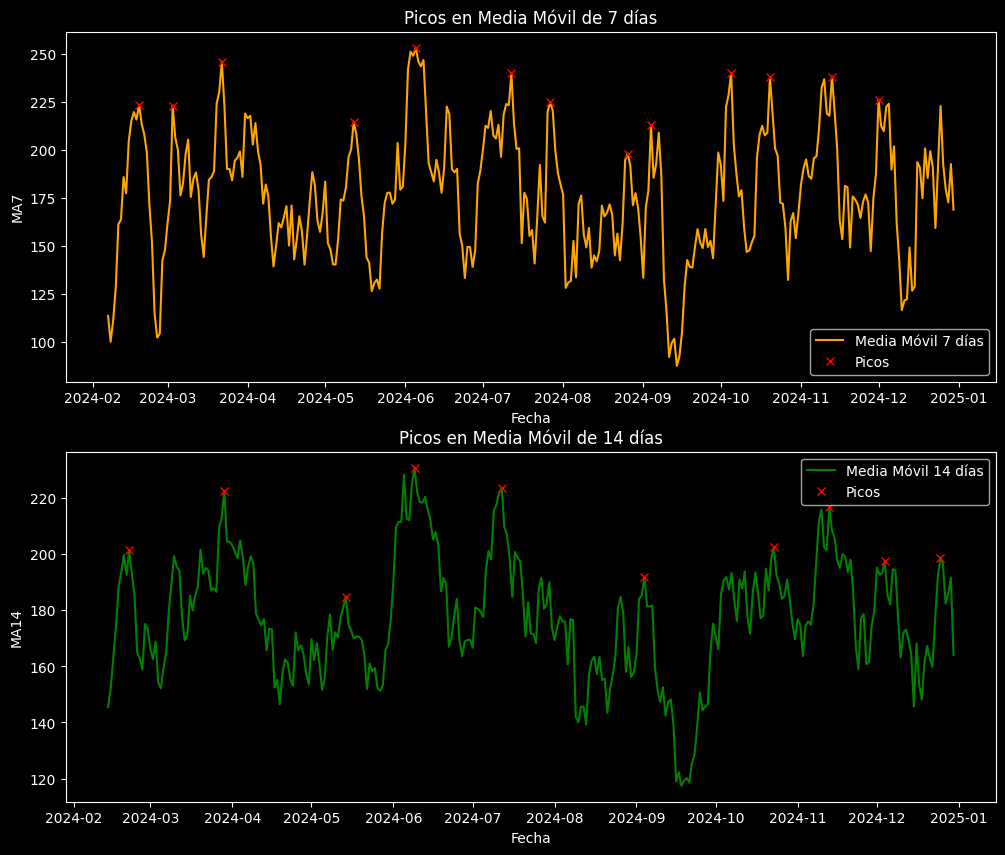

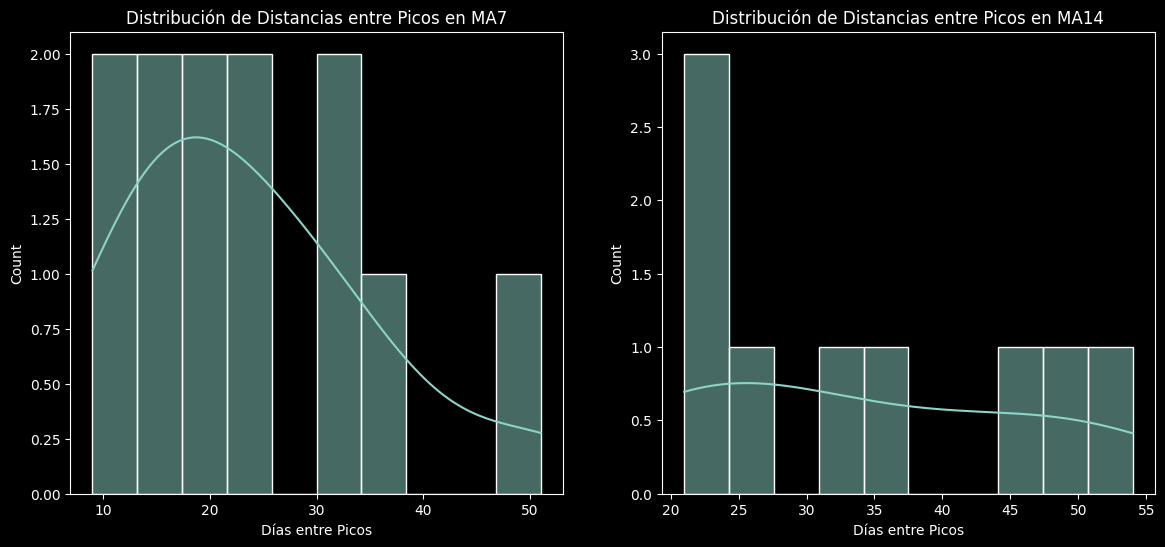

In [20]:
# Cuantificamos los picos de las medias moviles (cada cuanto se alcanza un maximo local)
peaks_7 = find_peaks(ventas_por_fecha['MA7'], prominence=60)[0]
peaks_14 = find_peaks(ventas_por_fecha['MA14'], prominence=30)[0]

print(f'Picos en MA7: {len(peaks_7)}, Picos en MA14: {len(peaks_14)}')

# Distancia promedio entre picos
distancias_7 = np.diff(peaks_7)
distancias_14 = np.diff(peaks_14)

print(f'Distancia promedio entre picos en MA7: {np.mean(distancias_7):.2f} días (rango: {np.min(distancias_7)} - {np.max(distancias_7)} días)')
print(f'Distancia promedio entre picos en MA14: {np.mean(distancias_14):.2f} días (rango: {np.min(distancias_14)} - {np.max(distancias_14)} días)')

# Plot picos en medias moviles
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
sns.lineplot(data=ventas_por_fecha, x='Fecha', y='MA7', ax=ax[0], label='Media Móvil 7 días', color='orange')
ax[0].plot(ventas_por_fecha['Fecha'].iloc[peaks_7], ventas_por_fecha['MA7'].iloc[peaks_7], "x", color='red', label='Picos')
ax[0].set_title('Picos en Media Móvil de 7 días')
ax[0].legend()
sns.lineplot(data=ventas_por_fecha, x='Fecha', y='MA14', ax=ax[1], label='Media Móvil 14 días', color='green')
ax[1].plot(ventas_por_fecha['Fecha'].iloc[peaks_14], ventas_por_fecha['MA14'].iloc[peaks_14], "x", color='red', label='Picos')
ax[1].set_title('Picos en Media Móvil de 14 días')
ax[1].legend()
plt.show()

# Plot distribucion de distancias entre picos
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(distancias_7, bins=10, kde=True, ax=ax[0])
ax[0].set_title('Distribución de Distancias entre Picos en MA7')
ax[0].set_xlabel('Días entre Picos')
sns.histplot(distancias_14, bins=10, kde=True, ax=ax[1])
ax[1].set_title('Distribución de Distancias entre Picos en MA14')
ax[1].set_xlabel('Días entre Picos')
plt.show()

/tmp/ipykernel_83966/4288540196.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=estacionalidad, x='Mes', y='Porcentaje_Desviacion', palette='coolwarm')


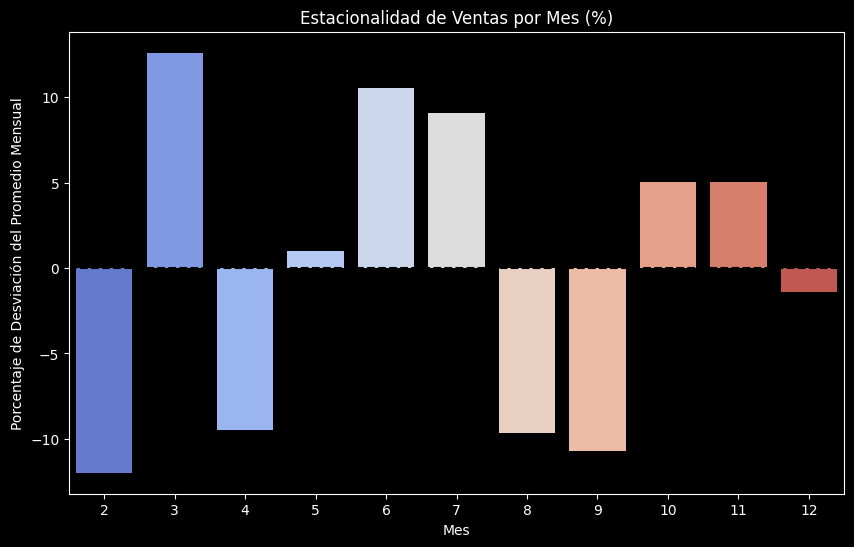

In [21]:
# Cuantificación de estacionalidad
df['Mes'] = df['Fecha'].dt.month
ventas_por_mes = df.groupby('Mes')['Monto_Venta'].sum().reset_index()
promedio_mensual = ventas_por_mes['Monto_Venta'].mean()
estacionalidad = ventas_por_mes.copy()
estacionalidad['Desviacion'] = estacionalidad['Monto_Venta'] - promedio_mensual
estacionalidad['Porcentaje_Desviacion'] = (estacionalidad['Desviacion'] / promedio_mensual) * 100

plt.figure(figsize=(10, 6))
sns.barplot(data=estacionalidad, x='Mes', y='Porcentaje_Desviacion', palette='coolwarm')
plt.title('Estacionalidad de Ventas por Mes (%)')
plt.xlabel('Mes')
plt.ylabel('Porcentaje de Desviación del Promedio Mensual')
plt.axhline(0, color='black', linestyle='--')
plt.show()

Podemos observar que el patron de ventas es estacional (es decir, no ha tendido a crecer o decrecer de forma consistente a lo largo del tiempo), pero con picos muy pronunciados. Estos picos no parecen depender del día de la semana.

Podemos observar tambien que hay ciertos meses con ventas  más altas que otros, esto puede indicar patrones en la demanda, aunque con datos de solamente un año es difícil de determinar si esto proviene de aleatoriedad o si es un patrón real.

Además, las medias moviles demuestran un patrón cíclico, con picos y valles que se repiten aproximadamente cada 0.5-2 meses. Esto sugiere que las ventas pueden estar influenciadas por factores estacionales o eventos periódicos.